In [1]:
import os
os.chdir('StableCascade')
import yaml
import torch
import zlib
import torch
import numpy as np
from tqdm import tqdm
from inference.utils import *
from core.utils import load_or_fail
from train import WurstCoreB
from scipy.stats import norm
from datasets import load_dataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config_file_b = 'configs/inference/stage_b_3b.yaml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    
core = WurstCoreB(config_dict=config_file_b, device=device, training=False)
extras = core.setup_extras_pre()
models = core.setup_models(extras)
models.generator.bfloat16();
extras.sampling_configs['cfg'] = 1.1
extras.sampling_configs['shift'] = 1
extras.sampling_configs['timesteps'] = 10
extras.sampling_configs['t_start'] = 1.0

['model_version', 'stage_a_checkpoint_path', 'effnet_checkpoint_path']
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']


In [3]:
def decompress_b4(compressed_batch, original_shape=(16,16,16), c_clip=torch.zeros(4,1,1280).cuda(), u_clip=torch.zeros(4,1,1280).cuda()):
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
        decompressed = [zlib.decompress(img) for img in compressed_batch]
        decompressed = [np.frombuffer(d, dtype=np.int8) for d in decompressed]
        decompressed = [d.reshape(original_shape) for d in decompressed]
        decompressed = [norm.ppf((d+0.5)/16) for d in decompressed]
        decompressed = [torch.tensor(d).cuda() for d in decompressed]
        decompressed = [d.unsqueeze(0) for d in decompressed]
        decompressed = torch.cat(decompressed)
        conditions = {
            'effnet': decompressed,
            'clip':   c_clip
        }
        unconditions = {
            'effnet': torch.zeros_like(decompressed),
            'clip':   u_clip
        }
        sampling_b = extras.gdf.sample(
            models.generator, conditions, (4, 4, 256, 256),
            unconditions, device=device, **extras.sampling_configs
        )
        print(decompressed.shape)
        for (sampled_b, _, _) in tqdm(sampling_b, total=extras.sampling_configs['timesteps']):
            sampled_b = sampled_b
        sampled = models.stage_a.decode(sampled_b).float()
        return sampled

In [ ]:
food101_train = load_dataset('danjacobellis/food101_cascade',split="train")
test_batch = food101_train[0:4]['compressed_image']
recovered_batch = decompress_b4(test_batch)
show_images(recovered_batch)

## Train

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import zlib
from fastprogress.fastprogress import master_bar, progress_bar
from torchvision.transforms import RandomCrop, CenterCrop, RandomHorizontalFlip, RandomErasing, Compose
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from scipy.stats import norm

In [2]:
def entropy_decode(sample):
    c = sample['compressed_image']
    d = zlib.decompress(c)
    d = np.frombuffer(d, dtype=np.int8)
    d = d.reshape((16,16,16))
    d = norm.ppf((d+0.5)/17)
    d = torch.tensor(d)
    sample['latent'] = d
    return sample

In [7]:
class CascadeClassifier(nn.Module):
    def __init__(self):
        super(CascadeClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=2048, kernel_size=5, stride=4, groups=16)
        self.layer_norm = nn.LayerNorm([2048, 3, 3])
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(in_channels=2048, out_channels=256, kernel_size=1)
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, 101)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer_norm(x)
        x = self.prelu(x)
        x = self.prelu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.prelu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
model = CascadeClassifier().cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [9]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params/1e6

1.84663

In [10]:
dataset = load_dataset('danjacobellis/food101_cascade').map(entropy_decode).remove_columns("compressed_image").with_format("torch")

Epoch: 1, Accuracy: 0.1588


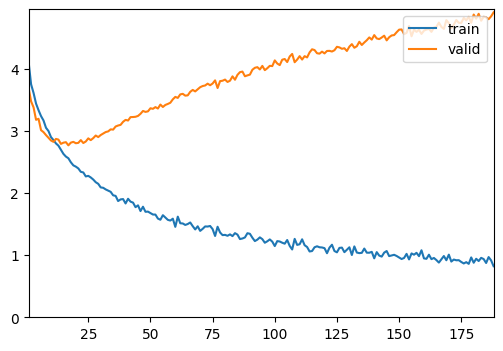

/home/dgj335/.local/lib/python3.10/site-packages/fastprogress/fastprogress.py:206: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)


Epoch: 2, Accuracy: 0.1900
Epoch: 3, Accuracy: 0.2093
Epoch: 4, Accuracy: 0.2442
Epoch: 5, Accuracy: 0.2383
Epoch: 6, Accuracy: 0.2772
Epoch: 7, Accuracy: 0.2844
Epoch: 8, Accuracy: 0.2926
Epoch: 9, Accuracy: 0.2990
Epoch: 10, Accuracy: 0.3070
Epoch: 11, Accuracy: 0.3120
Epoch: 12, Accuracy: 0.3000
Epoch: 13, Accuracy: 0.3057
Epoch: 14, Accuracy: 0.3225
Epoch: 15, Accuracy: 0.3171
Epoch: 16, Accuracy: 0.3172
Epoch: 17, Accuracy: 0.3272
Epoch: 18, Accuracy: 0.3233
Epoch: 19, Accuracy: 0.3198
Epoch: 20, Accuracy: 0.3254
Epoch: 21, Accuracy: 0.3227
Epoch: 22, Accuracy: 0.3198
Epoch: 23, Accuracy: 0.3288
Epoch: 24, Accuracy: 0.3225
Epoch: 25, Accuracy: 0.3192
Epoch: 26, Accuracy: 0.3254
Epoch: 27, Accuracy: 0.3203
Epoch: 28, Accuracy: 0.3207
Epoch: 29, Accuracy: 0.3189
Epoch: 30, Accuracy: 0.3173
Epoch: 31, Accuracy: 0.3176
Epoch: 32, Accuracy: 0.3196
Epoch: 33, Accuracy: 0.3180
Epoch: 34, Accuracy: 0.3131
Epoch: 35, Accuracy: 0.3097
Epoch: 36, Accuracy: 0.3139
Epoch: 37, Accuracy: 0.3082



KeyboardInterrupt



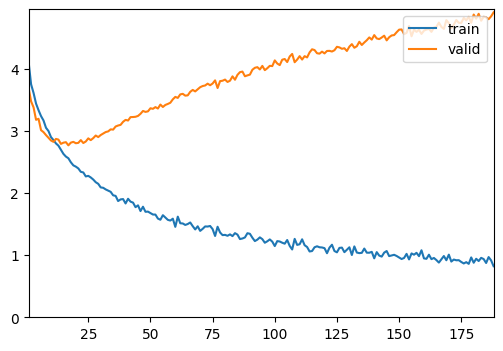

In [11]:
epochs = 200
mb = master_bar(range(1, epochs + 1))
train_loss = []
test_loss = []
val_accuracy = []
augmentations = Compose([
    RandomCrop(13),
    RandomHorizontalFlip(0.5),
    RandomErasing(p=0.5, scale=(1/169, 16/169), ratio=(1/13, 13), value=0, inplace=False),
])

center_crop = CenterCrop(13)

for epoch in mb:
    # Training Phase
    dataloader_train = DataLoader(dataset['train'], batch_size=1024, shuffle=True, drop_last=True)
    model.train()
    running_loss = 0.0
    for inputs in progress_bar(dataloader_train, parent=mb):
        x = augmentations(inputs['latent'].cuda())
        targets = inputs['label'].to(torch.int64).cuda()
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_function(outputs, targets)
        if torch.isnan(loss):
            print(f"Loss is nan, skipping batch")
            continue
        loss.backward()
        print(loss.item(), end='\r')
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    train_epoch_loss = running_loss / len(dataloader_train)
    train_loss.append(train_epoch_loss)
    
    # Validation Phase
    dataloader_val = DataLoader(dataset['validation'], batch_size=256, shuffle=False, drop_last=False)
    model.eval()
    running_loss_val = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs in dataloader_val:
            x = center_crop(inputs['latent'].cuda())
            targets = inputs['label'].to(torch.int64).cuda()
            outputs = model(x)
            loss = loss_function(outputs, targets)
            if torch.isnan(loss):
                print(f"Loss is nan, skipping batch")
                continue
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)
    val_epoch_loss = running_loss_val / len(dataloader_val)
    test_loss.append(val_epoch_loss)
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch: {epoch}, Accuracy: {epoch_accuracy:.4f}')
    val_accuracy.append(epoch_accuracy)
    graphs = [
        [range(1, epoch + 1), train_loss],  # Training Loss
        [range(1, epoch + 1), test_loss],  # Validation Loss
    ]
    x_bounds = [1, epoch]
    y_bounds = [min(min(train_loss + test_loss) - 0.05, 0), max(max(train_loss + test_loss) + 0.05, 1)]
    mb.update_graph(graphs, x_bounds, y_bounds)
    checkpoint_filename = f'checkpoint{epoch}.pt'
    torch.save(model.state_dict(), checkpoint_filename)